# Imports

In [1]:
# -*- coding: UTF-8 -*-

# Local packages:
import os

import pickle
import random
import time

# 3rd party packages:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from tqdm import tqdm,trange
from tkinter import Tk
from tkinter.filedialog import askopenfilenames
import ast 
import matplotlib.pyplot as plt
import gc
#from torch.utils.tensorboard import SummaryWriter
import neptune
from neptune.types import File
run = neptune.init_run(
    project="NTLAB/HypnoGAN",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhNGRjNDgzOC04OTk5LTQ0YTktYjQ4Ny1hMTE4NzRjNjBiM2EifQ==",
    source_files=["main.ipynb", "Data/create_dataset_csv.ipynb"],
)


#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
#torch.cuda.empty_cache()
#gc.collect()

# personal packages:
#from Data.preprocess import preprocess_data
#from model.timegan import TimeGAN
#from model.utils import timegan_trainer, timegan_generator

C:\Users\tomo9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\tomo9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\neptune\internal\backends\hosted_client.py:48: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
C:\Users\tomo9\AppData\Local\Temp\ipykernel_17864\221579484.py:26: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are dis

https://app.neptune.ai/NTLAB/HypnoGAN/e/HYPNOG-187


# Model

## Dataset class

In [2]:
class TimeGAN_Dataset(torch.utils.data.Dataset):
    """A time series dataset for TimeGAN.
    Args:
        data(numpy.ndarray): the padded dataset to be fitted. Has to transform to ndarray from DataFrame during initialize
        time(numpy.ndarray): the length of each data
    Parameters:
        - x (torch.FloatTensor): the real value features of the data
        - t (torch.LongTensor): the temporal feature of the data
    """
    def __init__(self,data, time=None):
        #sanity check data and time
        
        
        
        if isinstance(time,type(None)):
            time = [len(x) for x in data]
            
        if len(data) != len(time):
            run.stop()
            raise ValueError( f"len(data) `{len(data)}` != len(time) {len(time)}")
            
        
        self.X = torch.FloatTensor(data)
        self.T = torch.LongTensor(time)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,idx):
        return self.X[idx],self.T[idx]
    
    def collate_fn(self, batch):
        """Minibatch sampling
        """
        # Pad sequences to max length
        X_mb = [X for X in batch[0]]
        
        # The actual length of each data
        T_mb = [T for T in batch[1]]
        
        return X_mb, T_mb

## TimeGAN

In [3]:
class EmbeddingNetwork(nn.Module):
    """
    The embedding network (encoder) that maps the input data to a latent space.
    """
    def __init__(self, feature_dim, hidden_dim, num_layers, padding_value=0, max_seq_len=1000,arch='LSTM'):
        super(EmbeddingNetwork, self).__init__()
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.padding_value = padding_value
        self.max_seq_len = max_seq_len
        self.arch = arch
        
        #Embedder Architecture
        if self.arch.lower() == 'lstm':
            self.emb_rnn = nn.LSTM(
                input_size=self.feature_dim,
                hidden_size=self.hidden_dim,
                num_layers=self.num_layers,
                batch_first=True,
            )
        elif self.arch.lower() == 'gru':
            self.emb_rnn = nn.GRU(
                input_size=self.feature_dim,
                hidden_size=self.hidden_dim,
                num_layers=self.num_layers,
                batch_first=True,
            )
        else:
            raise ValueError(f'Embedder architecture has to be GRU or LSTM, but got {arch} instead!')
        self.emb_linear = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.emb_sigmoid = nn.Sigmoid()

        
        # Init weights
        # Default weights of TensorFlow is Xavier Uniform for W and 1 or 0 for b
        # Reference: 
        # - https://www.tensorflow.org/api_docs/python/tf/compat/v1/get_variable
        # - https://github.com/tensorflow/tensorflow/blob/v2.3.1/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py#L484-L61

        with torch.no_grad():
            for name, param in self.emb_rnn.named_parameters():
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(param.data)
                elif 'bias_ih' in name:
                    param.data.fill_(1)
                elif 'bias_hh' in name:
                    param.data.fill_(1)

            for name, param in self.emb_linear.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
                elif 'bias' in name:
                    param.data.fill_(0)
    def forward(self,X,T):
        """Forward pass of the embedding features from original space to latent space.
        Args:
            X: Input time series feature (B x S x F)
            T: INput temporal information (B)
        Returns:
            H: latent space embeddings (B x S x H)
        """
        # Dynamic RNN input for ignoring paddings

        X_pack = nn.utils.rnn.pack_padded_sequence(
            input =X,
            lengths=T,
            batch_first=True,
            enforce_sorted=False,
        )

        # 128*100*71
        H_o,H_t = self.emb_rnn(X_pack)

        #pad RNN output back to sequence length

        H_o,T = nn.utils.rnn.pad_packed_sequence(
            sequence=H_o,
            batch_first=True,
            padding_value=self.padding_value,
            total_length=self.max_seq_len,
        )

        #128*100*10
        logits = self.emb_linear(H_o)
        H = self.emb_sigmoid(logits)

        return H
    
class RecoveryNetwork(nn.Module):
    """The recovery network (decoder) for TimeGAN
    """
    def __init__(self,hidden_dim,feature_dim,num_layers,padding_value=0,max_seq_len=1000,arch='LSTM'):
        super(RecoveryNetwork, self).__init__()
        self.hidden_dim = hidden_dim
        self.feature_dim = feature_dim
        self.num_layers = num_layers
        self.padding_value = padding_value
        self.max_seq_len = max_seq_len
        self.arch = arch
        
        #Embedder Architecture
        if self.arch.lower() == 'lstm':
            self.rec_rnn = nn.LSTM(
                input_size=self.hidden_dim,
                hidden_size=self.hidden_dim,
                num_layers=self.num_layers,
                batch_first=True,
            )
        elif self.arch.lower() == 'gru':
            self.rec_rnn = nn.GRU(
                input_size=self.hidden_dim,
                hidden_size=self.hidden_dim,
                num_layers=self.num_layers,
                batch_first=True,
            )
        else:
            raise ValueError(f'Embedder architecture has to be GRU or LSTM, but got {arch} instead!')

        self.rec_linear = nn.Linear(self.hidden_dim, self.feature_dim)

        # Init weights
        # Default weights of TensorFlow is Xavier Uniform for W and 1 or 0 for b
        # Reference: 
        # - https://www.tensorflow.org/api_docs/python/tf/compat/v1/get_variable
        # - https://github.com/tensorflow/tensorflow/blob/v2.3.1/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py#L484-L614

        with torch.no_grad():
            for name,param in self.rec_rnn.named_parameters():
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    nn.init.xavier_uniform_(param.data)
                elif 'bias_ih' in name:
                    param.data.fill_(1)
                elif 'bias_hh' in name:
                    param.data.fill_(0)
            for name,param in self.rec_linear.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
                elif 'bias' in name:
                    param.data.fill_(0)
        
    def forward(self,H,T):
        """ Forward pass of the recovery features from latent space to original space.
        Args:
            H: latent representation (B x S x E)
            T: input temporal information (B)
        Returns:
            X_tilde: recovered features (B x S x F)
        """
        #Dynamic RNN input for ignoring paddings
        H_pack = nn.utils.rnn.pack_padded_sequence(
            input = H,
            lengths=T,
            batch_first=True,
            enforce_sorted=False,
        )
        #128 x 100 x 10
        H_o,H_t = self.rec_rnn(H_pack)
        #pad RNN output back to sequence length
        H_o,T = nn.utils.rnn.pad_packed_sequence(
            sequence=H_o,
            batch_first=True,
            padding_value=self.padding_value,
            total_length=self.max_seq_len,
        )
        #128 x 100 x 71
        X_tilde = self.rec_linear(H_o)
        return X_tilde

class SupervisorNetwork(nn.Module):
        """The supervisor network for TimeGAN
        """
        def __init__(self,hidden_dim,num_layers,padding_value=0,max_seq_len=1000,arch='LSTM'):
            super(SupervisorNetwork,self).__init__()
            self.hidden_dim =hidden_dim
            self.num_layers = num_layers
            self.padding_value = padding_value
            self.max_seq_len = max_seq_len

            self.arch = arch
        
            #Embedder Architecture
            if self.arch.lower() == 'lstm':
                self.sup_rnn = nn.LSTM(
                    input_size=self.hidden_dim,
                    hidden_size=self.hidden_dim,
                    num_layers=self.num_layers-1,
                    batch_first=True,
                )
            elif self.arch.lower() == 'gru':
                self.sup_rnn = nn.GRU(
                    input_size=self.hidden_dim,
                    hidden_size=self.hidden_dim,
                    num_layers=self.num_layers-1,
                    batch_first=True,
                )
            else:
                raise ValueError(f'Embedder architecture has to be GRU or LSTM, but got {arch} instead!')

            self.sup_linear = nn.Linear(self.hidden_dim,self.hidden_dim)
            self.sup_sigmoid = nn.Sigmoid()
             # Init weights
            # Default weights of TensorFlow is Xavier Uniform for W and 1 or 0 for b
            # Reference: 
            # - https://www.tensorflow.org/api_docs/python/tf/compat/v1/get_variable
            # - https://github.com/tensorflow/tensorflow/blob/v2.3.1/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py#L484-L614
            with torch.no_grad():
                for name, param in self.sup_rnn.named_parameters():
                    if 'weight_ih' in name:
                        torch.nn.init.xavier_uniform_(param.data)
                    elif 'weight_hh' in name:
                        torch.nn.init.xavier_uniform_(param.data)
                    elif 'bias_ih' in name:
                        param.data.fill_(1)
                    elif 'bias_hh' in name:
                        param.data.fill_(0)
                for name, param in self.sup_linear.named_parameters():
                    if 'weight' in name:
                        torch.nn.init.xavier_uniform_(param)
                    elif 'bias' in name:
                        param.data.fill_(0)
        def forward(self,H,T):
            """Forward pass for the supervisor for predicting next step
            Args:
                H: latent representation (B x S x E)
                T: input temporal information (B)
            Returns:
                H_hat: predicted next step data (B x S x E)
            """

            #Dynamic RNN input for ignoring paddings
            H_pack = nn.utils.rnn.pack_padded_sequence(
                input = H,
                lengths=T,
                batch_first=True,
                enforce_sorted=False,
            )

            H_o,H_t = self.sup_rnn(H_pack)
            #pad RNN output back to sequence length
            H_o,T = nn.utils.rnn.pad_packed_sequence(
                sequence=H_o,
                batch_first=True,
                padding_value=self.padding_value,
                total_length=self.max_seq_len,
            )
            logits = self.sup_linear(H_o)
            H_hat = self.sup_sigmoid(logits)
            return H_hat

class GeneratorNetwork(nn.Module):
    """The generator network for TimeGAN
    """
    def __init__(self,Z_dim,hidden_dim,num_layers,padding_value=0,max_seq_len=1000,arch='LSTM'):
        super(GeneratorNetwork,self).__init__()
        self.Z_dim = Z_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.padding_value = padding_value
        self.max_seq_len = max_seq_len
        self.arch = arch
        
        #Embedder Architecture
        if self.arch.lower() == 'lstm':
            self.gen_rnn = nn.LSTM(
                input_size=self.Z_dim,
                hidden_size=self.hidden_dim,
                num_layers=self.num_layers,
                batch_first=True,
            )
        elif self.arch.lower() == 'gru':
            self.gen_rnn = nn.GRU(
                input_size=self.Z_dim,
                hidden_size=self.hidden_dim,
                num_layers=self.num_layers,
                batch_first=True,
            )
        else:
            raise ValueError(f'Embedder architecture has to be GRU or LSTM, but got {arch} instead!')

        self.gen_linear = nn.Linear(self.hidden_dim,self.hidden_dim)
        self.gen_sigmoid = nn.Sigmoid()
                # Init weights
        # Default weights of TensorFlow is Xavier Uniform for W and 1 or 0 for b
        # Reference: 
        # - https://www.tensorflow.org/api_docs/python/tf/compat/v1/get_variable
        # - https://github.com/tensorflow/tensorflow/blob/v2.3.1/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py#L484-L614
        #aaa
        with torch.no_grad():
            for name, param in self.gen_rnn.named_parameters():
                if 'weight_ih' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'bias_ih' in name:
                    param.data.fill_(1)
                elif 'bias_hh' in name:
                    param.data.fill_(0)
            for name, param in self.gen_linear.named_parameters():
                if 'weight' in name:
                    torch.nn.init.xavier_uniform_(param)
                elif 'bias' in name:
                    param.data.fill_(0)
        
    def forward(self,Z,T):
        """ Takes in random noise (features) and generates synthetic features within the last latent space
        Args:
            Z: input random noise (B x S x Z)
            T: input temporal information (B)
        Returns:
            H: embeddings (B x S x E)
        """
        #Dynamic RNN input for ignoring paddings
        Z_pack = nn.utils.rnn.pack_padded_sequence(
            input=Z,
            lengths=T,
            batch_first=True,
            enforce_sorted=False,
        )

        # 128*100*71
        H_o,H_t = self.gen_rnn(Z_pack)

        #pad RNN output back to sequence length

        H_o,T = nn.utils.rnn.pad_packed_sequence(
            sequence=H_o,
            batch_first=True,
            padding_value=self.padding_value,
            total_length=self.max_seq_len,
        )

        #128*100*10
        logits = self.gen_linear(H_o)
        H = self.gen_sigmoid(logits)

        return H

class DiscriminatorNetwork(nn.Module):
    """The discriminator network for TimeGAN
    """
    def __init__(self,hidden_dim,num_layers,padding_value=0,max_seq_len=1000,arch='LSTM'):
        super(DiscriminatorNetwork,self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.padding_value = padding_value
        self.max_seq_len = max_seq_len
        self.arch = arch
        
        #Embedder Architecture
        if self.arch.lower() == 'lstm':
            self.dis_rnn = nn.LSTM(
                input_size=self.hidden_dim,
                hidden_size=self.hidden_dim,
                num_layers=self.num_layers,
                batch_first=True,
            )
        elif self.arch.lower() == 'gru':
            self.dis_rnn = nn.GRU(
                input_size=self.hidden_dim,
                hidden_size=self.hidden_dim,
                num_layers=self.num_layers,
                batch_first=True,
            )
        else:
            raise ValueError(f'Embedder architecture has to be GRU or LSTM, but got {arch} instead!')

        self.dis_linear = nn.Linear(self.hidden_dim,1)

        # Init weights
        # Default weights of TensorFlow is Xavier Uniform for W and 1 or 0 for b
        # Reference: 
        # - https://www.tensorflow.org/api_docs/python/tf/compat/v1/get_variable
        # - https://github.com/tensorflow/tensorflow/blob/v2.3.1/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py#L484-L614
        with torch.no_grad():
            for name, param in self.dis_rnn.named_parameters():
                if 'weight_ih' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'bias_ih' in name:
                    param.data.fill_(1)
                elif 'bias_hh' in name:
                    param.data.fill_(0)
            for name, param in self.dis_linear.named_parameters():
                if 'weight' in name:
                    torch.nn.init.xavier_uniform_(param)
                elif 'bias' in name:
                    param.data.fill_(0)
    
    def forward(self, H, T):
        """ Forward pass for predicting if the data is real or synthetic
        
        Args:
            H: latent representation (B x S x E)
            T: input temporal information (B)
        Returns:
        logits: prediction logits(B x S x 1)
        """
        # dynamic RNN input for ignoring paddings
        #print(f'H:{H.size}')
        H_pack = nn.utils.rnn.pack_padded_sequence(
            input = H,
            lengths=T,
            batch_first=True,
            enforce_sorted=False,
        )

        # 128*100*10
        #print(f'H pack:{H_pack.shape}')
        H_o,H_t = self.dis_rnn(H_pack)
        #print(f'H_o:{H_o.size},H_t:{H_t.size}')
        # pad RNN output back to sequence length
        H_o,T = nn.utils.rnn.pad_packed_sequence(
            sequence=H_o,
            batch_first=True,
            padding_value=self.padding_value,
            total_length=self.max_seq_len,
        )
        
        #TODO: check size of H_o
        #print(f'size of H_o:{H_o.size()}')
        #TODO get an output with the size of batch_size*1 so it gaves a result if the signal is real or not
        logits = self.dis_linear(H_o).squeeze(-1)
        #calulate mean of the logits
        logits = logits.mean(dim=1, keepdim=True)
        return logits

class TimeGAN(nn.Module):
    """ Implementation of TimeGan (Yoon et al., 2019) using PyTorch
    
    Reference:
        - Yoon, J., Jarret, D., van der Schaar, M. (2019). Time-series Generative Adversarial Networks. (https://papers.nips.cc/paper/2019/hash/c9efe5f26cd17ba6216bbe2a7d26d490-Abstract.html)
        - https://github.com/jsyoon0823/TimeGAN
    """
    def __init__(self,device,feature_dim,Z_dim,hidden_dim,max_seq_len,batch_size,num_layers,padding_value):
        super(TimeGAN,self).__init__()
        self.device =device
        self.feature_dim = feature_dim
        self.Z_dim = Z_dim
        self.hidden_dim = hidden_dim
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_layer = num_layers
        self.padding_value = padding_value

        self.embedder = EmbeddingNetwork(feature_dim=feature_dim,hidden_dim=hidden_dim,num_layers=num_layers,padding_value=padding_value,max_seq_len=max_seq_len)
        self.recovery = RecoveryNetwork(feature_dim=feature_dim,hidden_dim=hidden_dim,num_layers=num_layers,padding_value=padding_value,max_seq_len=max_seq_len)
        self.generator = GeneratorNetwork(Z_dim=Z_dim,hidden_dim=hidden_dim,num_layers=num_layers,padding_value=padding_value,max_seq_len=max_seq_len)
        self.discriminator = DiscriminatorNetwork(hidden_dim=hidden_dim,num_layers=num_layers,padding_value=padding_value,max_seq_len=max_seq_len)

        self.supervisor = SupervisorNetwork(hidden_dim=hidden_dim,num_layers=num_layers,padding_value=padding_value,max_seq_len=max_seq_len)

    def _recovery_forward(self, X, T):
        """ The embedding network forward pass and the embedder network loss
        Args:
            X: input features
            T: input temporal information
        Returns:
            E_loss: the reconstruction loss
            X_tilde: the reconstructed features
        """

        # FOrward pass
        H = self.embedder(X,T)
        X_tilde = self.recovery(H,T)

        #for Joint training
        H_hat_supervise = self.supervisor(H,T)
        G_loss_S = F.mse_loss(
            H_hat_supervise[:,:-1,:],
            H[:,1:,:],
        ) #Teacher forcing next output

        #Reconstruction loss
        E_loss_T0 = F.mse_loss(X_tilde,X)
        E_loss0 = 10*torch.sqrt(E_loss_T0)
        E_loss = E_loss0 + 0.1*G_loss_S
        return E_loss, E_loss0,E_loss_T0
    def _supervisor_forward(self, X, T):
        """ The supervisor training forward pass
        Args:
            X: original input features
            T: input temporal information
        Returns:
            S_loss: the supervisor's loss
        """
        #supervisor forward pass
        H = self.embedder(X,T)
        H_hat_supervise = self.supervisor(H,T)

        #supervised loss
        S_loss = F.mse_loss(
            H_hat_supervise[:,:-1,:],
            H[:,1:,:],
        ) #Teacher forcing next output
        return S_loss
    def _discriminator_forward(self, X, T, Z, gamma=1):
        """ The discriminator forward pass and adversarial loss
        Args:
            X: input features
            T: input temporal information
            Z: input noise
            gamma: the weight for the adversarial loss
        Returns:
            D_loss: adversarial loss
        """
        #Real
        H = self.embedder(X, T).detach()

        #generator
        E_hat = self.generator(Z,T).detach()
        H_hat = self.supervisor(E_hat,T).detach()
        
        #forward pass
        Y_real = self.discriminator(H,T)        #Encode original data
        Y_fake = self.discriminator(H_hat,T)    #Output of generator + supervisor
        Y_fake_e = self.discriminator(E_hat,T)  #Output of generator

        D_loss_real = F.binary_cross_entropy_with_logits(Y_real, torch.ones_like(Y_real))
        D_loss_fake = F.binary_cross_entropy_with_logits(Y_fake, torch.zeros_like(Y_fake))
        D_loss_fake_e = F.binary_cross_entropy_with_logits(Y_fake_e, torch.zeros_like(Y_fake_e))

        D_loss = D_loss_real + D_loss_fake + gamma * D_loss_fake_e

        return D_loss
    
    def _generator_forward(self, X, T, Z, gamma=1):
        """ The generator forward pass
        Args:
            X: original input features
            T: input temporal information
            Z: input noise for the generator
            gamma: the weight for the adversarial loss
        Returns:
            G_loss: the generator loss
        """
        #supervisor forward pass
        H = self.embedder(X,T)
        H_hat_supervise = self.supervisor(H,T)

        #generator forward pass
        E_hat = self.generator(Z,T)
        H_hat = self.supervisor(E_hat,T)
        
        #synthetic data generated
        X_hat = self.recovery(H_hat,T)

        #generator loss
        #Adversarial loss
        Y_fake = self.discriminator(H_hat,T)        #Output of supervisor
        Y_fake_e = self.discriminator(E_hat,T)      #Output of generator

        G_loss_U = F.binary_cross_entropy_with_logits(Y_fake, torch.ones_like(Y_fake))
        G_loss_U_e = F.binary_cross_entropy_with_logits(Y_fake_e, torch.ones_like(Y_fake_e))

        #Supervised loss
        G_loss_S = F.mse_loss(
            H_hat_supervise[:,:-1,:],
            H[:,1:,:],
        ) #Teacher forcing next output

        #Two moments losses
        G_loss_V1 = torch.mean(
            torch.abs(torch.sqrt(X_hat.var(dim=0,unbiased=False)+1e-6) - torch.sqrt(X.var(dim=0,unbiased=False)+1e-6))
        )
        G_loss_V2 = torch.mean(torch.abs((X_hat.mean(dim=0)) - (X.mean(dim=0))))
        G_loss_V = G_loss_V1 + G_loss_V2
        
        #sum of losses
        G_loss = G_loss_U + gamma * G_loss_U_e + 100 * torch.sqrt(G_loss_S) + 100 * G_loss_V
    
        return G_loss
    
    def _inference(self, Z,T):
        """ Inference for generating synthetic data
        Args:
            Z: input noise
            T: temporal information
        Returns:
            X_hat: the generated data
        """

        #generator forward pass
        E_hat = self.generator(Z,T)

        H_hat = self.supervisor(E_hat,T)

        #synthetic data generated
        X_hat = self.recovery(H_hat,T)
        return X_hat

    def forward(self,X,T,Z, obj, gamma=1):
        """
        Args:
            X: input features (B,H,F)
            T: The temporal information (B)
            Z: the sampled noise (B,H,Z)
            obj: the network to be trained ('autoencoder','supervisor','generator','discriminator')
            gamma: loss hyperparameter
        Returns:
            loss: loss for the forward pass
            X_hat: the generated data
        """

        #Move variables to device
        if obj !='inference':
            if X is None:
                run.stop()
                raise ValueError('X cannot be empty')
                
            
            X = torch.FloatTensor(X)
            X = X.to(self.device)

        if Z is not None:
            Z = torch.FloatTensor(Z)
            Z = Z.to(self.device)
        
        if obj == 'autoencoder':
            #embedder and recovery forward
            loss = self._recovery_forward(X,T)
        elif obj == 'supervisor':
            loss = self._supervisor_forward(X,T)
        elif obj == 'generator':
            if Z is None:
                run.stop()
                raise ValueError('Z cannot be empty')
                
            loss = self._generator_forward(X,T,Z,gamma)
        elif obj == 'discriminator':
            if Z is None:
                run.stop()
                raise ValueError('Z cannot be empty')
            loss = self._discriminator_forward(X,T,Z,gamma)
            return loss
        elif obj == 'inference':
            X_hat = self._inference(Z,T)
            #X_hat = X_hat.cpu.detach()
            X_hat = X_hat.detach().cpu()

            return X_hat
        else:
            run.stop()
            raise ValueError('obj must be autoencoder, supervisor, generator or discriminator')
        return loss
        

## Trainers

In [4]:
def embedding_trainer(
        model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        e_opt: torch.optim.Optimizer,
        r_opt: torch.optim.Optimizer,
        emb_epochs: int,
        writer 
):
    """
    Training loop for embedding and recovery functions.
    Args:
        model (torch.nn.Module): The model to train
        dataloader (torch.utils.data.DataLoader): The dataloader to use
        e_opt (torch.optim.Optimizer): The optimizer for the embedding function
        r_opt (torch.optim.Optimizer): The optimizer for the recovery function
        args (Dict): The model/training configuration
        writer (SummaryWriter): Neptune logger
    """
    logger = trange(emb_epochs, desc =f"Epoch:0, Loss:0")
    for epoch in logger:
        for X_mb,T_mb in dataloader:

            #reset gradients
            model.zero_grad()

            #forward pass
            _,E_loss0,E_loss_T0 = model(X=X_mb,T=T_mb,Z=None,obj="autoencoder")
            loss = np.sqrt(E_loss_T0.item())

            #backward pass
            E_loss0.backward()

            #update weights
            e_opt.step()
            r_opt.step()

        # Log loss for final batch of each epochs
        logger.set_description(f"Epoch:{epoch}, Loss:{loss:.4f}")
        writer['Embedding/Training_loss'].append(loss)
        """if writer:
            writer.add_scalar("Embedding/Loss:",loss,epoch)
            writer.flush()"""

def supervisor_trainer(
    model: torch.nn.Module, 
    dataloader: torch.utils.data.DataLoader, 
    s_opt: torch.optim.Optimizer, 
    g_opt: torch.optim.Optimizer,
    sup_epochs: int,
    writer
):
    """
    The training loop for the supervisor function
    Args:
        model (torch.nn.Module): The model to train
        dataloader (torch.utils.data.DataLoader): The dataloader to use
        s_opt (torch.optim.Optimizer): The optimizer for the supervisor function
        g_opt (torch.optim.Optimizer): The optimizer for the generator function
        args (Dict): The model/training configuration
        writer (Union[torch.utils.tensorboard.SummaryWriter, type(None)], optional): The tensorboard writer to use. Defaults to None.
    """
    logger = trange(sup_epochs, desc=f"Epoch: 0, Loss: 0")
    for epoch in logger:
        for X_mb, T_mb in dataloader:
            # Reset gradients
            model.zero_grad()

            # Forward Pass
            S_loss = model(X=X_mb, T=T_mb, Z=None, obj="supervisor")

            # Backward Pass
            S_loss.backward()
            loss = np.sqrt(S_loss.item())

            # Update model parameters
            s_opt.step()

        # Log loss for final batch of each epoch (29 iters)
        logger.set_description(f"Epoch: {epoch}, Loss: {loss:.4f}")
        writer['Supervisor/Training_loss'].append(loss)
        """if writer:
            writer.add_scalar(
                "Supervisor/Loss:",loss,epoch)
            writer.flush()"""

In [5]:
def joint_trainer(
    model: torch.nn.Module, 
    dataloader: torch.utils.data.DataLoader, 
    e_opt: torch.optim.Optimizer, 
    r_opt: torch.optim.Optimizer, 
    s_opt: torch.optim.Optimizer, 
    g_opt: torch.optim.Optimizer, 
    d_opt: torch.optim.Optimizer,
    sup_epochs: int,
    batch_size: int,
    max_seq_len: int,
    Z_dim: int,
    dis_thresh: float,
    writer
    ):
    """
    The training loop for training the model altogether
    Args:
        model (torch.nn.Module): The model to train
        dataloader (torch.utils.data.DataLoader): The dataloader to use
        e_opt (torch.optim.Optimizer): The optimizer for the embedding function
        r_opt (torch.optim.Optimizer): The optimizer for the recovery function
        s_opt (torch.optim.Optimizer): The optimizer for the supervisor function
        g_opt (torch.optim.Optimizer): The optimizer for the generator function
        d_opt (torch.optim.Optimizer): The optimizer for the discriminator function
        args (Dict): The model/training configuration
        writer (Union[torch.utils.tensorboard.SummaryWriter, type(None)], optional): The tensorboard writer to use. Defaults to None.
    """
    logger = trange(
        sup_epochs, 
        desc=f"Epoch: 0, E_loss: 0, G_loss: 0, D_loss: 0"
    )
    for epoch in logger:
        for X_mb, T_mb in dataloader:
            ## Generator Training
            for _ in range(2):
                # Random Generator
                Z_mb = torch.rand((batch_size, max_seq_len, Z_dim))

                # Forward Pass (Generator)
                model.zero_grad()
                G_loss = model(X=X_mb, T=T_mb, Z=Z_mb, obj="generator")
                G_loss.backward()
                G_loss = np.sqrt(G_loss.item())

                # Update model parameters
                g_opt.step()
                s_opt.step()

                # Forward Pass (Embedding)
                model.zero_grad()
                E_loss, _, E_loss_T0 = model(X=X_mb, T=T_mb, Z=Z_mb, obj="autoencoder")
                E_loss.backward()
                E_loss = np.sqrt(E_loss.item())
                
                # Update model parameters
                e_opt.step()
                r_opt.step()

            # Random Generator
            Z_mb = torch.rand((batch_size, max_seq_len, Z_dim))

            ## Discriminator Training
            model.zero_grad()
            # Forward Pass
            D_loss = model(X=X_mb, T=T_mb, Z=Z_mb, obj="discriminator")


            # Check Discriminator loss
            if D_loss > dis_thresh:
                # Backward Pass
                D_loss.backward()

                # Update model parameters
                d_opt.step()
            D_loss = D_loss.item()
        if epoch%50 == 0:
            
        logger.set_description(
            f"Epoch: {epoch}, E: {E_loss:.4f}, G: {G_loss:.4f}, D: {D_loss:.4f}"
        )
        
        writer['Joint/E_loss'].append(E_loss)
        writer['Joint/G_loss'].append(G_loss)
        writer['Joint/D_loss'].append(D_loss)

def timegan_trainer(model,train_data,train_time,batch_size,lr,emb_epochs,sup_epochs,max_seq_length,Z_dim,dis_thresh,device,model_path,writer):
    """
    The trainign procedure for TimeGAN.
    Args:
        model (torch.nn.module): The model that generates synthetic data
        loaded_data(pandas.DataFrame): The data to train on, including data and time
        args (Dict): The model/training configuration
    Returns:
        generated_data (np.array): The synthetic data generated by the model
    """
    dataset = TimeGAN_Dataset(data=train_data,time=train_time)
    dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)
    model.to(device)

    #initialize optimizers
    e_opt = torch.optim.Adam(model.embedder.parameters(), lr=lr)
    r_opt = torch.optim.Adam(model.recovery.parameters(), lr=lr)
    s_opt = torch.optim.Adam(model.supervisor.parameters(), lr=lr)
    g_opt = torch.optim.Adam(model.generator.parameters(), lr=lr)
    d_opt = torch.optim.Adam(model.discriminator.parameters(), lr=lr)

    #initialize tensorboard writer
    #writer = SummaryWriter(os.path.join(f"tensorboard/{args.exp}"))

    print("\nStart Embedding Network Training")
    embedding_trainer(model=model, dataloader=dataloader, e_opt=e_opt, r_opt=r_opt, emb_epochs=emb_epochs,writer=writer)

    print("\nStart Training with Supervised Loss Only")
    supervisor_trainer(model=model, dataloader=dataloader, s_opt=s_opt,g_opt=g_opt, sup_epochs=sup_epochs,writer=writer)

    print("\nStart Joint Training")
    joint_trainer(model=model, dataloader=dataloader, e_opt=e_opt, r_opt=r_opt, s_opt=s_opt, g_opt=g_opt, d_opt=d_opt, sup_epochs=sup_epochs, batch_size=batch_size, max_seq_len=max_seq_length, Z_dim=Z_dim, dis_thresh=dis_thresh,writer=writer)


    #save model,args, and hyperparameters
    #torch.save(args,f"{args.model_path}/args.pickle")
    torch.save(model.state_dict(),f"{model_path}/model.pt")
    
    print(f"Model saved to {model_path}")

def timegan_generator(model,T,model_path,batch_size, max_seq_len, Z_dim ,device):
    """
    The interference procedure for TimeGAN.
    Args:
        model (torch.nn.module): The model that generates synthetic data
        T (List[int]): The time to generate data for
        args (Dict): The model/training configuration
    returns:
        generated_data (np.array): The synthetic data generated by the model
    """
    #load model
    if not os.path.exists(model_path):
        run.stop()
        raise ValueError(f"Model not found at {model_path}")
    model.load_state_dict(torch.load(f"{model_path}/model.pt",map_location=device))
    model.to(device)
    #print("\nStart Generating Synthetic Data")
    #Initialize model to evaluation mode and run without gradients
    model.to(device)
    model.eval()
    with torch.no_grad():
        # Random Generator
        #print(f'random generated Z dims: {batch_size,max_seq_len,Z_dim}')
        Z = torch.rand((batch_size, max_seq_len, Z_dim))
        # Forward Pass (Generator)
        generated_data = model(X=None, T=T, Z=Z, obj="inference")
    return generated_data.numpy()

# Data handling

## Data loading

In [6]:
def load_data(writer,data_limit=None,save_dataset=None):
    """
    data_limit=None,save_dataset=None
    Load and preprocess real life datasets.
    
    Args:
        data_limit (int): The number of data points to load. If None, all data points are loaded. Default: None. Used for testing.
        save_dataset (bool): If 'Full', the dataset is saved to a csv file. If it's 'limited', than save the limited dataset if data_limit is not None. Default: None.


    Returns:
        dataset (pandas.DataFrame): The dataset.
    
    """

    main_dataset = pd.DataFrame()
    cluster = True
    if cluster == False:
        Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
        filenames = askopenfilenames() # show an "Open" dialog box and return the path to the selected file
        print(filenames)
        for filename in filenames:
            
            if filename.endswith('.mat'):
                #output df format: [id,value_array]
                df = load_mat_as_df(filename)
                print(df)
            
            elif filename.endswith('.csv'):

                #use create_dataset_csv.py to create a csv file
                if filename.find('dataset') != -1:
                    df = pd.read_csv(filename,sep=';',index_col=0)

                """ CSV format:
                ID|time|Sleeping stage|length|additional_info

                """
                pass

            elif filename.endswith('.xml'):
                ## TODO: add xml support
                #df =
                pass
            else:
                print("Unsupported file format, skipping file:",filename,".")
                pass
        
            main_dataset.append(df)
    else:
        #load datasets from cluster
        filename = "Data/generated_dataset.csv"
        writer["Dataset"].track_files(filename)
        main_dataset = pd.read_csv(filename,sep=';',index_col=0)

    #Cut df to data_limit size for testing purposes
    if data_limit is not None:
        if data_limit < len(main_dataset):
            print(f'The length of the dataset is {len(main_dataset)}, the new length is {data_limit}')
            main_dataset = main_dataset[:data_limit]
        elif data_limit >= len(main_dataset):
            print("data_limit is bigger than the dataset size, using the whole dataset")
    elif data_limit <= 0 or data_limit == '':
        print("data_limit is 0 or less, using the whole dataset")
    #print the headers of the dataset
    #print(main_dataset.head())
    # transform dataset.time and dataset.Sleeping stage to float and int
    #print(main_dataset)
    #main_dataset.time = main_dataset.time.apply(string_to_float_array)
    mask = main_dataset['Sleeping_stage'].str.contains('nan', na=False)

    # drop the rows that contain 'NaN' as part of the string
    main_dataset = main_dataset[~mask]
    main_dataset['Sleeping_stage'] = main_dataset['Sleeping_stage'].apply(string_to_int_array)
    
    print(main_dataset.head())
    return main_dataset #dataset as df

def load_mat_as_df(mat_file_path, var_name):
    mat = sio.loadmat(mat_file_path,simplify_cells=True)

    if var_name not in list(mat.keys()):
        var_name = get_variable_name(mat)   
        

    return pd.DataFrame(mat[var_name])

def get_variable_name(loaded_mat):

    
    root = tk.Tk()
    root.title('.mat variable selector')
    tk.Label(root, text="Choose a variable:").pack()
    choices = list(loaded_mat.keys())

    variable = tk.StringVar(root)
    variable.set(choices[0]) # default value
    w = tk.Combobox(root, textvariable=variable,values=choices)

    w.pack()
    def ok():
        print ("value is:" + variable.get())
        root.destroy()
    def cancel():
        root.destroy()
        raise InterruptedError('User cancelled, invalid variable name')

    button1 = tk.Button(root, text="OK", command=ok)
    button2 = tk.Button(root, text="Cancel", command=cancel)
    button1.pack()
    button2.pack()
    root.mainloop()
    
    return variable.get()
def string_to_float_list(s):
    return [float(x) for x in s.strip('[]').split(',')]
def string_to_int_list(s):
    return [int(x) for x in s.strip('[]').split(',')]
def string_to_float_array(s):
    """Convert array-as-string to float array"""
    return [float(x) for x in ast.literal_eval(s)]
def string_to_int_array(s):
    """Convert array-as-string to int array"""
    return [int(x) for x in ast.literal_eval(s)]

def deconstruct_array(array):
    """Dismantle ID x length x 1 array to ID x length x 6 based on x1 values."""    
    new_array = np.zeros((array.shape[0],array.shape[1],6))
    i_max = array.shape[0]-1
    j_max = array.shape[1]-1
    for i in range(i_max):
        for j in range(j_max):
            new_array[i,j,int(array[i,j,0])] = 1
    return new_array
def reconstruct_array(array):
    """Remake ID x length x 6 array to ID x length x 1 based on x1 values."""
    #print(f'array shape: {array.shape}')
    
    new_array = np.zeros((array.shape[0],array.shape[1],1))
    i_max = array.shape[0]-1
    j_max = array.shape[1]-1
    for i in range(i_max):
        for j in range(j_max):
            new_array[i,j,0] = np.argmax(array[i,j,:])
    return new_array


## Data preprocess

In [7]:
def preprocess_data(writer,padding_value,len_limit=0.2,data_limit=None,save_dataset=None,norm_enable=False,deconst_enable=False):
    """
    padding_value: int = -1.0,
    data_limit: int = None"""
    # Load and preprocess data
    # 
    # Steps:
    # 0. Sanity checks
    # 1. Load data from files (csv,mat,xml)
    # 2. Preprocess data:
    # 2.1. Remove outliers
    # 2.2. Extract sequence length and time
    # 2.3. Resample data
    # 2.4. Normalize data
    # 2.5. Padding
    # 3 Save data to csv file
    #  
    # Args:
    #     data_limit (int): The number of lines to load from the data file. If None, all data points are loaded. Default: None. Used for testing.
    #     padding_value (int): The value used for padding
    #     save_dataset (bool): If 'Full', the dataset is saved to a csv file. If it's 'limited', than save the limited dataset if data_limit is not None. Default: None.
    #     norm_enable (bool): If True, normalize the data. Default: False.
    #     
    # 
    # Returns:
    #     prep_data (pandas.DataFrame): The processed data

    #######################################
    # 0. Sanity checks
    #######################################
    
    # Check if save_dataset is valid
    if save_dataset is not None:
        if save_dataset.lower =='none':
            save_dataset = None
        elif save_dataset.lower =='full':
            save_dataset = 'Full'
        elif save_dataset.lower =='limited':
            save_dataset = 'Limited'
        else:
            raise ValueError('save_dataset must be None, Full or Limited')
    # Check if data_limit is valid
    if data_limit is not None:
        if isinstance(data_limit, str) == True:
            data_limit= None
        elif isinstance(data_limit, float) == True and data_limit.is_integer() == True:
            data_limit = int(data_limit)
        elif isinstance(data_limit, int) == True:
            pass
        else:
            raise ValueError('data_limit must be None or int')
    # Check if padding_value is valid
    if isinstance(padding_value, str) == True:
        raise ValueError('padding_value must be int')
    elif isinstance(padding_value, float) == True and padding_value.is_integer() == True:
        padding_value = int(padding_value)
    elif isinstance(padding_value, int) == True:
        pass
    else:
        raise ValueError('padding_value must be int')
    # Check if norm_enable is valid
    if isinstance(norm_enable, bool) == True:
        pass
    elif isinstance(norm_enable, str) == True:
        if norm_enable.lower() == 'true':
            norm_enable = True
        elif norm_enable.lower() == 'false':
            norm_enable = False
        else:
            raise ValueError('norm_enable must be bool')
    else:
        raise ValueError('norm_enable must be bool')


    #######################################
    # 1. Load data from files (csv,mat,xml)
    #######################################

    loaded_data = load_data(writer=writer,data_limit=data_limit,save_dataset=save_dataset)
    """
    loaded data =       time_data   , data  , length
    (pandas.DataFrame), (np.array)  ,(list) ,(int)
    
    ()
    """
    #convert data to np.array
    #loaded_data['data'] = loaded_data['data'].apply(lambda x: np.array(x))
    
    #######################################
    # 2. Preprocess data:
    #######################################
    # 2.1. Remove outliers
    #######################################
    """
    Remove row's with unacceptable sleep stages values
    """
    
    sleep_stages = np.array([1,2,3,4,5])
    loaded_data[loaded_data['Sleeping_stage'].apply(lambda x: all(elem in sleep_stages for elem in x))]

    #######################################
    # 2.2. Extract sequence length and time
    #######################################
    """
    Extract sequence length of all lines and time of each line
    """
    loaded_data['length'] = loaded_data['Sleeping_stage'].apply(lambda x: len(x))
    if len_limit != 0:
        #plot length distribution
        fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(10,5))
        ax1.hist(loaded_data['length'], )
        ax1.set_title('Original length distribution')
        _,bins,_=ax1.hist(loaded_data['length'])
        # drop rows with +- 10% of mean length
        #caluclate mean length 
        mean_len = loaded_data.length.mean()
        #df = df[df['Age'] <= 1.1 * mean_age]
        loaded_data=loaded_data[loaded_data['length'] <= (1+len_limit) *mean_len]
        loaded_data=loaded_data[loaded_data['length'] >=(1-len_limit)*mean_len]
        ax2.hist(loaded_data['length'],bins=bins,)
    else:
        fig, ax1 = plt.subplots(ncols=1,figsize=(10,5))
        ax1.hist(loaded_data['length'])
    writer['Length_comp'].upload(fig)
    plt.close()
    #######################################
    # 2.4. Normalize data
    #######################################
    """
    Normalize data to [0,1] using MinMaxScaler algorithm
    """

    

    if norm_enable == True:
        loaded_data['Sleeping_stage']=MinMaxNormalizer(loaded_data['Sleeping_stage'])
    

    #######################################
    # 2.5. Padding
    #######################################
    """
    Padding data to given length
    """
    #print(f'length of all row: {loaded_data.length}')
    max_len = max(loaded_data['length'])
    length = len(loaded_data)
    #get the number of columns in the data
    dim =len(loaded_data.columns)-1
    # Question: Current padding value is 0, is it ok? Do we need it or just resample?
    data_info = {
        'length' : length,
        'max_length' : max_len,
        'paddding_value_stage' : padding_value,
        'dim' : dim
    }

    loaded_data['Sleeping_stage'] = loaded_data['Sleeping_stage'].apply(lambda x: np.transpose(x))
    
    prep_data = pd.DataFrame(columns=['Sleeping_stage','time'])
    print(f'Padding data to {max_len} length')

    #shape: [length, max_len,features] = [length, max_len,1]
    # init empty array
    padded_data = np.empty((length,max_len,1))
    #fill array with padding value
    padded_data.fill(padding_value)

    time = []

    for i in tqdm(range(length)):
        #get a row of Sleep stage data
        tmp_stage = loaded_data.iloc[i]['Sleeping_stage']
        #print tmp_stage type
        #print(tmp_stage.shape)

        #impute missing values
        #tmp_stage = impute_missing_values(tmp_stage)
        
        #get time data
        tmp_time = len(tmp_stage)
        #reshape tmp_stage to [tmp_time,1]
        tmp_stage = tmp_stage.reshape(tmp_time,1)
        # pad data to 'max_seq_len'
        if len(tmp_stage) >= max_len:
            padded_data[i,:,:] = tmp_stage[:max_len,0:]
            time.append(max_len)
        else:
            padded_data[i,:tmp_time,:] = tmp_stage[:,0:]
            time.append(len(tmp_stage))
    if deconst_enable:
        padded_data=deconstruct_array(padded_data)
        
    return padded_data, time, data_info    
    
def impute_missing_values(
        curr_data: np.ndarray,
        )-> np.ndarray:
    """ArithmeticError
    Impute missing values in data.
    Args:
        curr_data: 1-D array of data.
    
    Returns:
        data: 1-D array of data with missing values filled.
    """
    index = range(1,len(curr_data)+1)
    curr_data = pd.DataFrame(data=curr_data,index=index,columns=['data'])
    #impute data
    imputed_data=curr_data.fillna(1)
    
    # check for any N/A values
    if imputed_data.isnull().any().any():
        raise ArithmeticError('Missing values were not imputed correctly')
    print(f'imputed data is {imputed_data.data[0].dtype}')
    return imputed_data.to_numpy()




    """
    for i in tqdm(range(length)):
        #create empty array with padding value
        tmp_stage = np.empty(max_len)
        #fill array with padding value
        tmp_stage.fill(padding_value)
        #fill array with data
        print(f'padding shape {tmp_stage.shape}, while data shape is {loaded_data.iloc[i]["Sleeping_stage"].shape}')
        #np.copyto(tmp_stage,loaded_data.iloc[i]['Sleeping_stage'])
        tmp_stage[0:len(loaded_data['Sleeping_stage'][i])]=loaded_data['Sleeping_stage'][i]
        #create empty array for padded time
        #tmp_time = np.empty(max_len)
        #fill array with padding value
        #tmp_time.fill(time_pad)
        #fill array with data
        #np.copyto(tmp_time,loaded_data.iloc[i]['time'])
        #tmp_time[0:len(loaded_data['time'][i])]=loaded_data['time'][i]

        #append to prep_data
        #prep_data = prep_data.append({'time':tmp_time,'Sleeping_stage':tmp_stage},ignore_index=True)
        tmp_time = len(tmp_stage)
        prep_data=prep_data.append({'Sleeping_stage':tmp_stage,'time':tmp_time},ignore_index=True)
        

    # add index column to prep_data
    #prep_data['index'] = prep_data.index
    


    # 3.1 Save dataset to file
    if save_dataset == 'Full':
        #save dataset to a csv file
        prep_data.to_csv('full_dataset.csv',sep=';')
    elif save_dataset == 'Limited':
        if data_limit is not None or data_limit != '' or data_limit > 0:
            #save dataset as limited dataset
            prep_data.to_csv('limited_dataset.csv',sep=';')
        else:
            print(f"Warning: data_limit is {data_limit} which is not supported value, dataset is not limited, saving full dataset.")
            prep_data.to_csv('full_dataset.csv',sep=';')
    elif save_dataset is None or save_dataset == '':
        pass
    else:
        run.stop()
        raise ValueError("Invalid save_dataset value, valid values are \'Full\',\'Limited\',None.")
    """
    """for i in tqdm(range(length)):
        #create empty array with padding value
        tmp_array = np.empty([max_len,1])
        tmp_array.fill(padding_value)
        #fill array with data
        tmp_array[:loaded_data['Sleeping_stage'][i].shape[0],:loaded_data['Sleeping_stage'][i].shape[1]] = loaded_data['Sleeping_stage'][i]
        #append to prep_data
        prep_data.append(tmp_array)
    """
    #print data type of prepared data.time
    #print(f'prep_data time type is {type(prep_data.time[0])}')
    #print(f'prep_data shape is {prep_data}')
    #print(f'prep_data time shape is {prep_data.time.shape}')
    #print(f'prep_data Sleeping_stage shape is {prep_data.Sleeping_stage.shape}')
    
    #save dataset to a csv file
    #prep_data.to_csv('test_dataset.csv',sep=';')


    #

    #return prep_data.Sleeping_stage ,prep_data.time,data_info
    

    
    
    


def MinMaxNormalizer(data,min_value=1,max_value=5):
    numerator = data-min_value
    denominator = max_value-min_value
    norm_data = numerator/denominator
    return norm_data

# Main

## Utils

## Main

In [8]:
#######################################
# Experiment Arguments
#######################################
#experiment name
exp_name ="test_decosntLSTM1"
# Train
is_train = False
# Enableing x1 to x6 transormation:
deconst_enable = True
#torch.cuda.set_device(1)
# select device:
device = "cuda"

#set random seed
seed = 0



#normalization enable
norm_enable = False

# padding value
padding_value = 0.0



# dataset save:
# Full: save full dataset
# Limited: save limited dataset
# None: don't save dataset
save_dataset = None



# save arguments to neptune
run["Initialization/Arguments/ExperimentArgs/device"] = device
run["Initialization/Arguments/ExperimentArgs/seed"] = seed
run["Initialization/Arguments/ExperimentArgs/exp_name"] = exp_name
run["Initialization/Arguments/ExperimentArgs/norm_enable"] = norm_enable
run["Initialization/Arguments/ExperimentArgs/padding_value"] = padding_value
run["Initialization/Arguments/ExperimentArgs/is_train"] = is_train
#run["Initialization/Arguments/ExperimentArgs/save_dataset"] = save_dataset


#######################################
# Data Arguments
#######################################

#data limit for testing
# None: use full dataset
# int: use limited dataset
data_limit = 1000

#train test split rate
train_rate = 0.4
# save arguments to neptune
run["Initialization/Arguments/DataArgs/data_limit"] = data_limit
run["Initialization/Arguments/DataArgs/train_rate"] = train_rate

#######################################
# Model Arguments
#######################################

# embedding model epochs
emb_epochs = 2

# GAN model epochs
gan_epochs = 2

# supervised model epochs
sup_epochs = 2

# batch size
batch_size = 64

# hidden dimension of RNN
hidden_dim = 6

# number of layers in RNN
num_layers = 3

# discriminator threshold
dis_thresh = 0.15

#learning rate
lr = 1e-3


# save arguments to neptune
run["Initialization/Arguments/ModelArgs/embedding_epochs"] = emb_epochs
run["Initialization/Arguments/ModelArgs/gan_epochs"] = gan_epochs
run["Initialization/Arguments/ModelArgs/supervised_epochs"] = sup_epochs
run["Initialization/Arguments/ModelArgs/batch_size"] = batch_size
run["Initialization/Arguments/ModelArgs/hidden_dim"] = hidden_dim
run["Initialization/Arguments/ModelArgs/num_layers"] = num_layers
run["Initialization/Arguments/ModelArgs/discriminator_threshold"] = dis_thresh
run["Initialization/Arguments/ModelArgs/learning_rate"] = lr



######################################
# Initialize output directories
######################################
## runtime directory
code_dir = os.path.abspath(".")
if not os.path.exists(code_dir):
    run.stop()
    raise ValueError(f"Code directory not found at {code_dir}")

## Data directory
data_path = os.path.abspath("./Data")
if not os.path.exists(data_path):
    run.stop()
    raise ValueError(f"Data directory not found at {data_path}")
data_dir = os.path.dirname(data_path)
data__file_name = os.path.basename(data_path)
## Output directory
model_path = os.path.abspath(f"./Output/{exp_name}/")
out_dir = os.path.abspath(model_path)

if not os.path.exists(out_dir):
    os.makedirs(out_dir,exist_ok=True)

print(f"Code directory:\t\t\t{code_dir}")
print(f"Data directory:\t\t\t{data_path}")
print(f"Output directory:\t\t{out_dir}")

 ######################################
# Initialize random seed and CUDA
######################################
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device == "cuda" and torch.cuda.is_available():
    print("Using CUDA\n")
    device = torch.device("cuda:0")
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    print("Using CPU\n")
    device = torch.device("cpu")




Code directory:			c:\Users\tomo9\Documents\00_School\00_Thesis\HypnoGAN
Data directory:			c:\Users\tomo9\Documents\00_School\00_Thesis\HypnoGAN\Data
Output directory:		c:\Users\tomo9\Documents\00_School\00_Thesis\HypnoGAN\Output\test_decosntLSTM1
Using CUDA



In [9]:

######################################
# Load and preprocess data for model
######################################
X,T,loaded_data_info = preprocess_data(writer=run,len_limit=0.4,padding_value=padding_value,data_limit=data_limit,save_dataset=save_dataset,norm_enable=norm_enable,deconst_enable=True)
#print(X)
#print(f"Processed Data: {X.shape} (Idx x Max_Sequence_Length x Features(=1))")
print(f'Original data shape: {X.shape}')
#print(f"Original data preview:\n{X[:2, :10, :]}\n")
feature_dim = X.shape[-1]
Z_dim = X.shape[-1]
#print(f'feature_dim: {feature_dim}, Z_dim: {Z_dim}')

max_seq_len = loaded_data_info['max_length']
 # Train-Test Split data and time
 # TODO: Same people should be in the same pool at train test split
 # Make the split on the subject ID's, so also have to att ID to the loaded data
train_data, test_data, train_time, test_time = train_test_split(
    X, T, test_size=train_rate, random_state=seed
)
print(f'Train dataset length is {len(train_time)}, Test dataset length is {len(test_data)}')
#########################
# Initialize and Run model
#########################
 # Log start time
start = time.time()
#init TimeGAN model
model = TimeGAN(device=device,feature_dim=feature_dim,Z_dim=Z_dim,  hidden_dim=hidden_dim, num_layers=num_layers, max_seq_len=max_seq_len,batch_size=batch_size,padding_value=padding_value)

#model = TimeGAN(feature_dim=feature_dim,  hidden_dim=hidden_dim, num_layers=num_layers, max_seq_len=max_seq_len,padding_value=padding_value)
if is_train == True:
    timegan_trainer(model,train_data,train_time,batch_size=batch_size,lr=lr,emb_epochs=emb_epochs,sup_epochs=sup_epochs,max_seq_length=max_seq_len,Z_dim=Z_dim,dis_thresh=dis_thresh,device=device,model_path=model_path,writer=run)

# Log end time
end = time.time()





The length of the dataset is 9350, the new length is 1000
                                                        Sleeping_stage  \
File name                                                                
abc-baseline-900001  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
abc-baseline-900002  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
abc-baseline-900003  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
abc-baseline-900004  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
abc-baseline-900005  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                     length  additional_info  
File name                                     
abc-baseline-900001    1027              NaN  
abc-baseline-900002     985              NaN  
abc-baseline-900003    1030              NaN  
abc-baseline-900004    1101              NaN  
abc-baseline-900005    1016              NaN  
Padding data to 1186 length


100%|██████████| 987/987 [00:00<00:00, 16727.12it/s]


Original data shape: (987, 1186, 6)
Train dataset length is 592, Test dataset length is 395


In [10]:

#generated_time=test_time[:64]
print(int(np.ceil(len(test_time)/batch_size)))
logger = trange(int(np.ceil(len(test_time)/batch_size)), desc=f"Batch: 0/{int(np.ceil(len(test_time)/batch_size))}, current length: {0}")
for i in logger:
    start_pos = i*batch_size
    end_pos = start_pos+batch_size
    if end_pos > len(test_time):
        end_pos = len(test_time)
    tmp_time = test_time[start_pos:end_pos]
   
    tmp_data = timegan_generator(model, tmp_time, model_path=model_path,batch_size=batch_size,max_seq_len=max_seq_len,Z_dim=Z_dim,device=device)
    if deconst_enable:
      results =reconstruct_array(tmp_data)
    else:
      results = tmp_data
    
    if i !=0:
        #print(f'gen shape: {generated_data.shape}, res_shape: {results.shape}')
        generated_data=np.concatenate((generated_data,results))
        generated_time=np.concatenate((generated_time,tmp_time))
    else:
        generated_data=results
        generated_time=tmp_time
        #print(generated_data.shape)
    logger.set_description(f"Batch:{i}/{int(np.ceil(len(test_time)/batch_size))}, current length: {end_pos}")
    
    


#generated_data = timegan_generator(model, test_time, model_path=model_path,batch_size=batch_size,max_seq_len=max_seq_len,Z_dim=Z_dim,device=device)
print(f'generated data shape:{generated_data.shape}')
#recosntruct data if deconst_enabledeconst_enable = true

print(f"Generated data preview:\n{generated_data[:1, :, :]}\n")
print(f"Model Runtime: {(end - start)/60} mins\n")
# Save splitted data and generated data
with open(f"{model_path}/train_data.pickle", "wb") as fb:
    pickle.dump(train_data, fb)
    run["pickled_train_data"].upload(File.as_pickle(train_data))
with open(f"{model_path}/train_time.pickle", "wb") as fb:
    pickle.dump(train_time, fb)
    run["pickled_train_time"].upload(File.as_pickle(train_time))
with open(f"{model_path}/test_data.pickle", "wb") as fb:
    pickle.dump(test_data, fb)
    run["pickled_test_data"].upload(File.as_pickle(test_data))
with open(f"{model_path}/test_time.pickle", "wb") as fb:
    pickle.dump(test_time, fb)
    run["pickled_test_time"].upload(File.as_pickle(test_time))
with open(f"{model_path}/fake_data.pickle", "wb") as fb:
    pickle.dump(generated_data, fb)
    run["pickled_fake_data"].upload(File.as_pickle(generated_data))
with open(f"{model_path}/fake_time.pickle", "wb") as fb:
    pickle.dump(generated_time, fb)
    run["pickled_fake_time"].upload(File.as_pickle(generated_time))


7


Batch:6/7, current length: 395: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


generated data shape:(395, 1186, 1)
Generated data preview:
[[[1.]
  [2.]
  [2.]
  ...
  [0.]
  [0.]
  [0.]]]

Model Runtime: 8.207559585571289e-05 mins



In [11]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 6 operations to synchronize with Neptune. Do not kill this process.
All 6 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/NTLAB/HypnoGAN/e/HYPNOG-184/metadata


# Test:

In [ ]:
"""Remake ID x length x 5 array to ID x length x 1 based on x1 values."""


def fnc(array):
    print(f'array shape: {array.shape}')
    
    new_array = np.zeros((array.shape[0],array.shape[1],1))
    i_max = array.shape[0]-1
    j_max = array.shape[1]-1
    for i in range(i_max):
        for j in range(j_max):
            new_array[i,j,0] = np.argmax(array[i,j,:])
    print(new_array.shape)
    return new_array
array = fnc(generated_data)
print(array.shape)

torch.Size([64, 1186, 1])
(395, 1186, 1)


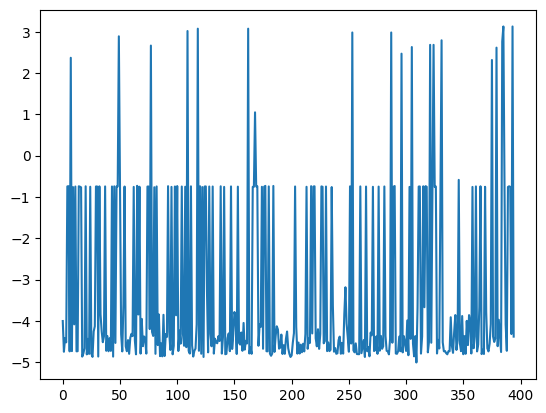

In [11]:
import matplotlib.pyplot as plt
#plt.plot(generated_data[1,:200])
Z = torch.rand(64, 1186, 1).to(device)
print(Z.shape)
print(generated_data.shape)
gen=deconstruct_array(generated_data)
gen_torch = torch.from_numpy(gen)
#a =model._discriminator_forward(X=gen_torch[0].to(device),T=test_time[0],Z=Z)
gen_torch=gen_torch.float()
b=model.embedder.forward(gen_torch.to(device),test_time)
c=model.discriminator.forward(H=b,T=test_time)
#print(c[0])
c_=c.detach().cpu().numpy()
plt.plot(c_)

tensor([995])
roudned:[[[0 1 0 0 0 0]
  [0 1 0 0 0 0]
  [0 1 0 0 0 0]
  ...
  [1 0 1 0 1 1]
  [1 0 1 0 1 1]
  [1 0 1 0 1 1]]]
recon:(1, 1186, 1)


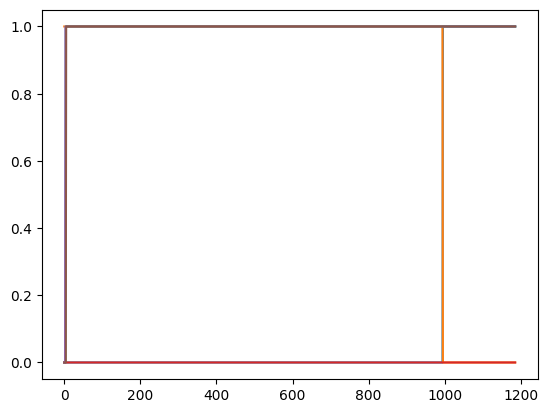

In [55]:
def disc_gen_hypnogram(data,time,model,device):
    #line-by-line
    #logger = trange(len(data),desc=f'Hypnogram nr. {0}/{len(data)}')
    #data=data.astype(float)
    #print(type(data[0]))
    #deconed_data=deconstruct_array(data)
    #deconed_data=float(deconed_data)
    gen=deconstruct_array(data)
    gen_as_torch = torch.from_numpy(gen)
    gen_as_torch=gen_as_torch.float()
    embedded_data = model.embedder.forward(gen_as_torch.to(device), time)
    discriminated_data = model.discriminator.forward(H=embedded_data,T=time)
    detached_data=discriminated_data.detach().cpu().numpy()
    #plt.plot(detached_data[0])
    plt.plot(discriminated_data.detach().cpu().numpy())
    return detached_data
                    
#result = disc_gen_hypnogram(data=generated_data,time=test_time,model=model,device=device)
#print(result)
def gen_batch_hypnogram(model,device,time=None,Z=None,batch_size=64,max_seq_len=1000,Z_dim=6,min_len=0,max_len=1000):
    
    #random noise
    if Z is None:
        if time is not None:
            Z = torch.rand((len(time), max_seq_len, Z_dim))
        else:
            Z = torch.rand((1,max_seq_len,Z_dim))
    else:    
        Z = torch.FloatTensor(Z)
        Z = Z.to(device)
    if time is None:
        #generate random time length information
        time = torch.randint(min_len,max_len,(1,),dtype=torch.int64)
        print(time)
        #time = torch.IntTensor(time)
        #time = time.to(device)
    #time=time.to(device)
    Z = Z.to(device)
    model.to(device)
    #print(Z)
    #print(time)
    gen_data = model.generator(Z,time)
    a = gen_data.detach().cpu().numpy()
    #rounded=np.round(gen_data.detach().cpu().numpy()).astype(int)
    rounded=np.where(a >= 0.5, 1, 0)
    print(f'roudned:{rounded}')
    recons = reconstruct_array(rounded)
    print(f'recon:{recons.shape}')
    #print(f'gen data:{gen_data}')
    plt.plot(rounded[0])

gen_data= gen_batch_hypnogram(model=model,device=device,min_len=990)
#def disc_hypnogram()
def rounder(data):
    if data >= 0.5:
        return 1
    elif data < 0.5:
        return 0
                       
        
    

# Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, mean_squared_error


# Evaluation variables:
feat_pred_no = 2

In [ ]:
#########################
# Preprocess data for seeker
#########################
# Define enlarge data and its labels
enlarge_data = np.concatenate((train_data, test_data), axis=0)
enlarge_time = np.concatenate((train_time, test_time), axis=0)
enlarge_data_label = np.concatenate((np.ones([train_data.shape[0], 1]), np.zeros([test_data.shape[0], 1])), axis=0)
# Mix the order
idx = np.random.permutation(enlarge_data.shape[0])
enlarge_data = enlarge_data[idx]
enlarge_data_label = enlarge_data_label[idx]

## 1. Feature prediction

In [ ]:
def feature_prediction(train_data, test_data, index):
    """Use the other features to predict a certain feature.

    Args:
    - train_data (train_data, train_time): training time-series
    - test_data (test_data, test_data): testing time-series
    - index: feature index to be predicted

    Returns:
    - perf: average performance of feature predictions (in terms of AUC or MSE)
    """
    train_data, train_time = train_data
    test_data, test_time = test_data

    # Parameters
    no, seq_len, dim = train_data.shape

    # Set model parameters

    args = {}
    args["device"] = "cuda"
    args["task"] = "regression"
    args["model_type"] = "gru"
    args["bidirectional"] = False
    args["epochs"] = 20
    args["batch_size"] = 128
    args["in_dim"] = dim-1
    args["h_dim"] = dim-1
    args["out_dim"] = 1
    args["n_layers"] = 3
    args["dropout"] = 0.5
    args["padding_value"] = -1.0
    args["max_seq_len"] = 100
    args["learning_rate"] = 1e-3
    args["grad_clip_norm"] = 5.0

    # Output initialization
    perf = list()
  
    # For each index
    for idx in index:
        # Set training features and labels
        train_dataset = FeaturePredictionDataset(
            train_data, 
            train_time, 
            idx
        )
        train_dataloader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=args["batch_size"],
            shuffle=True
        )

        # Set testing features and labels
        test_dataset = FeaturePredictionDataset(
            test_data, 
            test_time,
            idx
        )
        test_dataloader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=no,
            shuffle=False
        )

        # Initialize model
        model = GeneralRNN(args)
        model.to(args["device"])
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=args["learning_rate"]
        )

        logger = trange(args["epochs"], desc=f"Epoch: 0, Loss: 0")
        for epoch in logger:
            running_loss = 0.0

            for train_x, train_t, train_y in train_dataloader:
                train_x = train_x.to(args["device"])
                train_y = train_y.to(args["device"])
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                train_p = model(train_x, train_t)
                loss = criterion(train_p, train_y)
                # backward
                loss.backward()
                # optimize
                optimizer.step()

                running_loss += loss.item()

            logger.set_description(f"Epoch: {epoch}, Loss: {running_loss:.4f}")

        
        # Evaluate the trained model
        with torch.no_grad():
            temp_perf = 0
            for test_x, test_t, test_y in test_dataloader:
                test_x = test_x.to(args["device"])
                test_p = model(test_x, test_t).cpu().numpy()

                test_p = np.reshape(test_p, [-1])
                test_y = np.reshape(test_y.numpy(), [-1])
        
                temp_perf = rmse_error(test_y, test_p)
      
        perf.append(temp_perf)
    
    return perf

In [ ]:

feat_idx = np.random.permutation(train_data.shape[2])[:feat_pred_no]
print("Running feature prediction using original data...")
ori_feat_pred_perf = feature_prediction(
    (train_data, train_time), 
    (test_data, test_time),
    feat_idx
)
print("Running feature prediction using generated data...")
new_feat_pred_perf = feature_prediction(
    (generated_data, generated_time),
    (test_data, test_time),
    feat_idx
)
feat_pred = [ori_feat_pred_perf, new_feat_pred_perf]
print('Feature prediction results:\n' +
      f'(1) Ori: {str(np.round(ori_feat_pred_perf, 4))}\n' +
      f'(2) New: {str(np.round(new_feat_pred_perf, 4))}\n')

In [ ]:
main_dataset1 = pd.DataFrame()
filename1 = "Data/generated_dataset_SHHS.csv"
main_dataset1 = pd.read_csv(filename1,sep=';',index_col=0)

main_dataset2 = pd.DataFrame()
filename2 = "Data/generated_dataset_ABC.csv"
main_dataset2 = pd.read_csv(filename2,sep=';',index_col=0)

#main_dataset1= main_dataset1[:len(main_dataset2)]
print(f'len1: {len(main_dataset1)},len2: {len(main_dataset2)}')
diff = pd.concat([main_dataset1, main_dataset2]).drop_duplicates(keep=False)
#print(diff)
#print(main_dataset)
#print(main_dataset.head())
#for i in range(len(main_dataset.Sleeping_stage)):
#    print(type(main_dataset.Sleeping_stage[i]))

main_dataset2['Sleeping_stage'] = main_dataset2['Sleeping_stage'].apply(string_to_int_array)


mask = main_dataset1['Sleeping_stage'].str.contains('nan', na=False)

# drop the rows that contain 'NaN' as part of the string
main_dataset1 = main_dataset1[~mask]
print(len(main_dataset1))

main_dataset1['Sleeping_stage'] = main_dataset1['Sleeping_stage'].apply(string_to_float_array)
def string_to_int_array(s):
    return [int(x) for x in ast.literal_eval(s)]
def string_to_float_array(s):
    return [float(x) for x in ast.literal_eval(s)]
